In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from generate_video import *

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
SEQ_LEN = 4

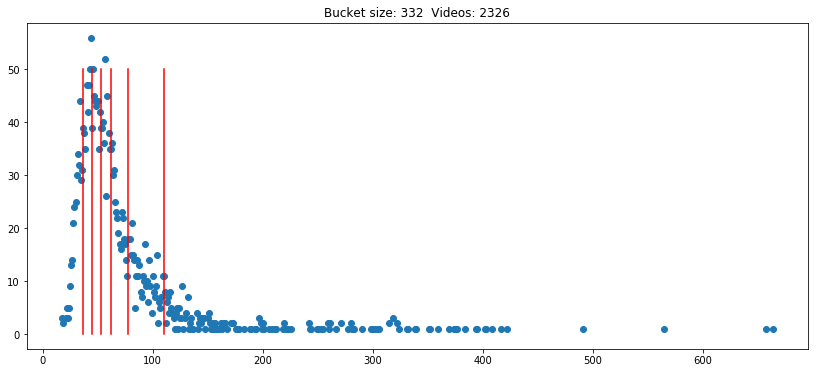

<bound method MultiVideoDataset.clear of <generate_video.MultiVideoDataset object at 0x7f1b7a6e0ac8>>


In [5]:
dset = MultiVideoDataset(seqlen=SEQ_LEN, speedup=4, shuffle=False, bins=7, plot_buckets=True)
print(dset.clear)

In [9]:
(frames, mask_pafs, mask_heats), (pafs, heats), reset_flag = dset.next_batch(bsize=1)

print(frames.shape)
print(mask_pafs.shape, mask_heats.shape)
print(pafs.shape, heats.shape)

(1, 4, 368, 368, 3)
(1, 4, 46, 46, 38) (1, 4, 46, 46, 19)
(1, 4, 46, 46, 38) (1, 4, 46, 46, 19)


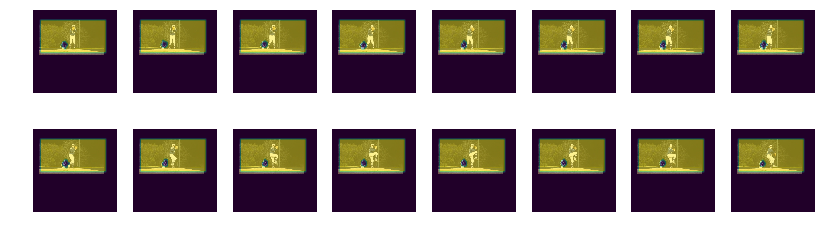

In [13]:
import matplotlib.pyplot as plt

for vid in dset.streams: vid.reset()

plt.figure(figsize=(14, 4))
for ii in range(4):
    (frames, mask_pafs, mask_heats), (pafs, heats), reset = dset.next_batch(bsize=1)
    for sii in range(SEQ_LEN):
        plt.subplot(2, 8, ii*SEQ_LEN+sii+1)
        plt.axis('off')
        plt.imshow(cv2.cvtColor(frames[0][sii], cv2.COLOR_BGR2RGB))
        mask = cv2.resize(mask_pafs[0][sii][:, :, 0], (0,0), fx=8, fy=8)
        plt.imshow(mask, alpha=0.5)
plt.show()
plt.close()

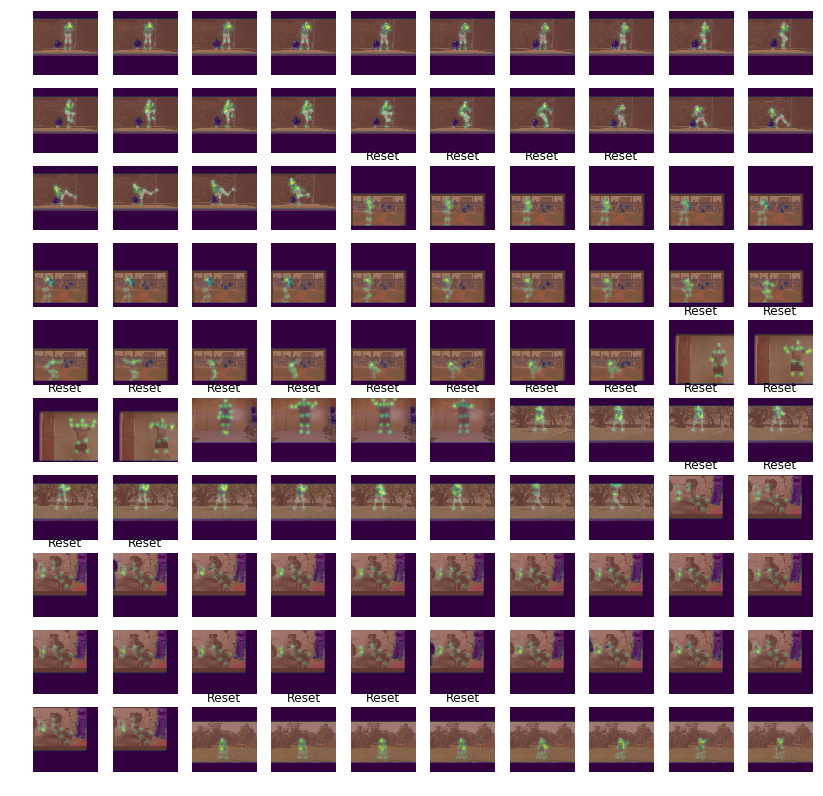

In [14]:
import matplotlib.pyplot as plt

# demonstrate that videos get played end-to-end

for video in dset.streams: video.reset()

plt.figure(figsize=(14, 14))
for ii in range(25):
    (frames, mask_pafs, mask_heats), (pafs, heats), reset = dset.next_batch(bsize=1)
    for sii in range(SEQ_LEN):
        plt.subplot(10, 10, ii*SEQ_LEN+sii+1)
        plt.gca().set_title('Reset' if  reset else '')
        plt.axis('off')
        plt.imshow(cv2.cvtColor(frames[0][sii], cv2.COLOR_BGR2RGB))
        mask = cv2.resize(mask_heats[0][sii][:, :, 0], (0,0), fx=8, fy=8)
        plt.imshow(mask.astype(np.float32), alpha=0.5)
        points = cv2.resize(np.sum(heats[0][sii][:, :, :-1].astype(np.float32), -1), (0,0), fx=8, fy=8)
        plt.imshow(points.astype(np.float32), alpha=0.5)
plt.show()
plt.close()

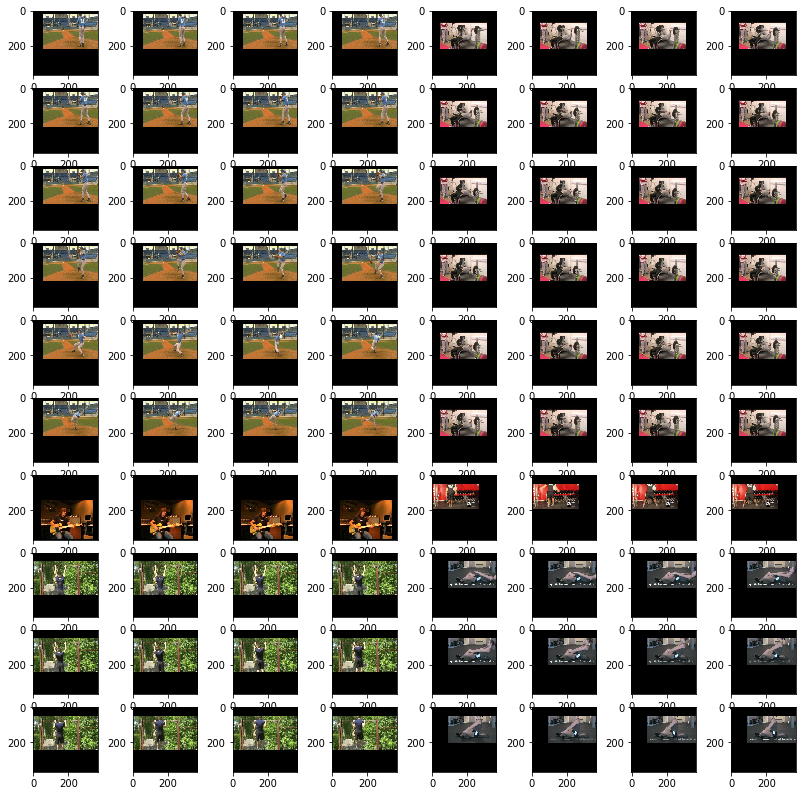

In [10]:
# demonstrate that videos started in the same batch will share playback length

dset.clear()
# for video in dset.streams: video.reset()

plt.figure(figsize=(14, 14))
for ii in range(10):
  
    (frames, mask_pafs, mask_heats), (pafs, heats), reset_flag = dset.next_batch(bsize=2)
    for jj in range(2):  
        for kk in range(SEQ_LEN):
            plt.subplot(10, 8, ii*8 + SEQ_LEN*jj + kk + 1)
            plt.imshow(cv2.cvtColor(frames[jj][kk], cv2.COLOR_BGR2RGB))
plt.show()
plt.close()

In [11]:
import time
import os, sys
# measure bach time

hist = []
for ii in range(100):
    t0 = time.time()
    dset.next_batch(bsize=6)
    dt = time.time() - t0
    sys.stdout.write('%d: %.2f\r' % (ii, dt))
    hist.append(dt)
    sys.stdout.flush()

avg = np.mean(hist)
print(avg * 10000)
print(avg)

 [!] WARN: batch size changed!
9064.016580581665
0.9064016580581665


In [13]:
dset = MultiVideoDataset(seqlen=4, speedup=2, shuffle=False, bins=7)

[185.5, 190.75, 185.5, 190.75]


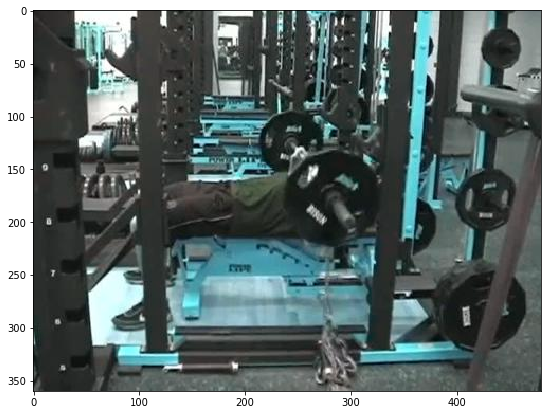

[32.33333333333333, 78.33333333333333, 32.33333333333333, 78.33333333333333]


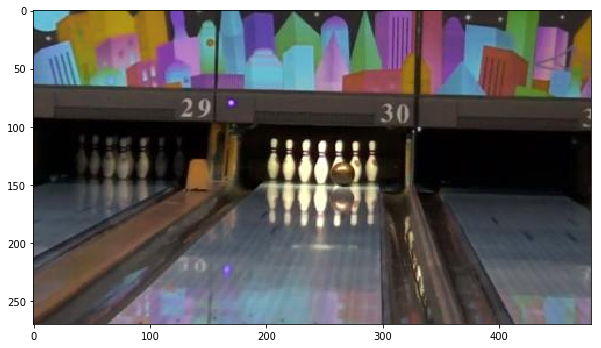

In [20]:
from cv2 import imread

box_ratios = []
for bucket in dset.buckets:
    for video in bucket:
        midind = int(len(video.frames)/2)
        img = imread(video.frames[midind])
        imsize = img.shape[:2]
        x0, y0, xf, yf = video.boxes[midind]
        barea = (xf - x0) * (yf - y0)
        imarea = imsize[0] * imsize[1]
        fill = barea / imarea
        try:
            assert fill <= 1.0
            assert fill > 0
        except:
            print(video.boxes[midind])
            plt.figure(figsize=(10, 7))
            plt.imshow(img)
            plt.show()
            plt.close()
        box_ratios.append(fill)

0.0 0.9255486968449929


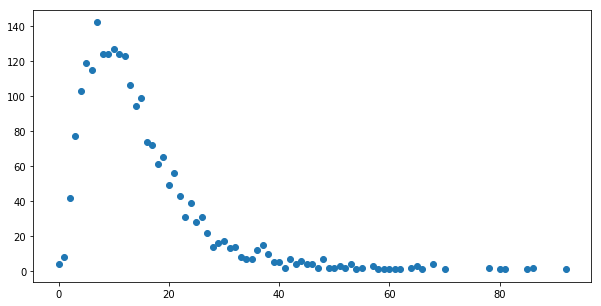

In [24]:
print(np.min(box_ratios), np.max(box_ratios))

dist = np.zeros(100)
for ratio in box_ratios:
    dist[int(ratio * 100)] += 1
    

xs = []
ys = []
for ii, sum in enumerate(dist):
    if sum > 0:
        xs += [ii]
        ys += [sum]

plt.figure(figsize=(10, 5))
plt.scatter(xs, ys)
plt.show()